In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import s2_selection_utility as ssu

Start import
Working on midway2-0412.rcc.local with the following versions 
and installation paths:
strax
	v0.13.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.14.4	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [31]:
def plot_area_width_aft(run_id, low = 0, high = 6, low2 = 0, high2 = 1, binning = 500):
    events = st.get_array(run_id,'event_info')
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_area'], events['s1_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    #plt.yscale('log')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

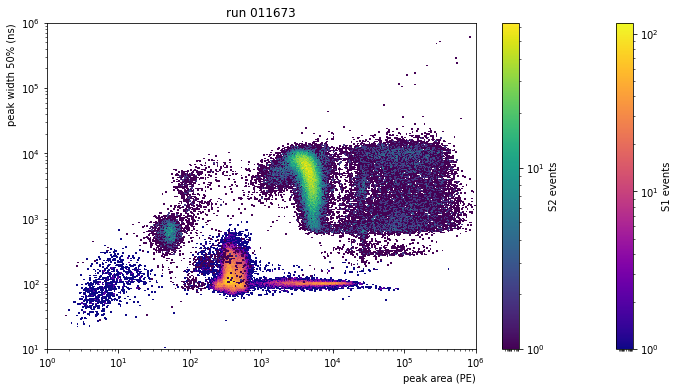

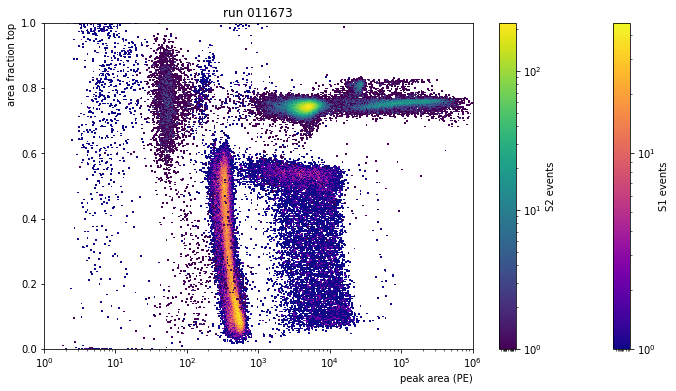

In [32]:
run_kr = '011673'
plot_area_width_aft(run_kr)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

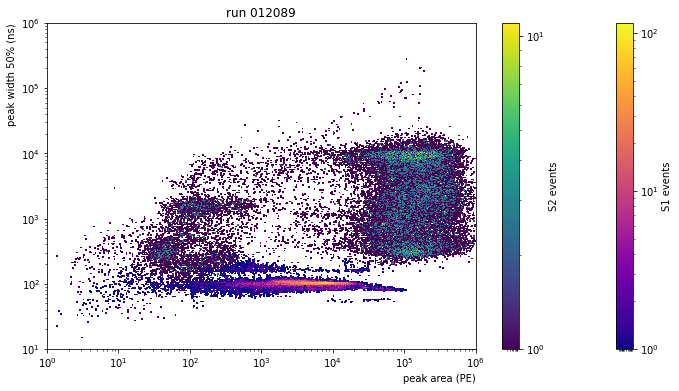

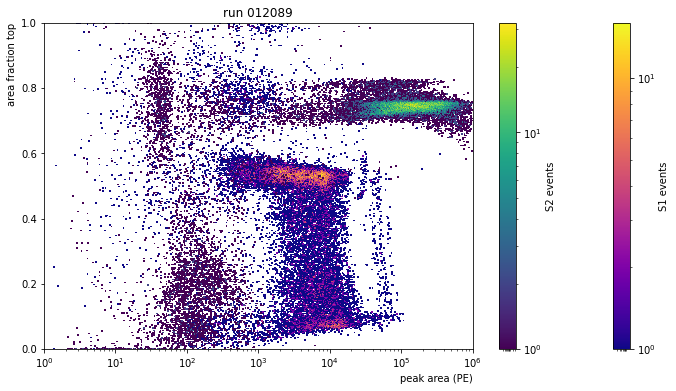

In [33]:
run_bkg = '012089'
plot_area_width_aft(run_bkg)

In [100]:
def drift_velocity(run_id, area_bounds, aft_bounds, width_bounds, low = 0, high = 6000, binning = 500):
    events = st.get_array(run_id,'event_info')

    events = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    
    plt.figure(figsize=(12,6))
    dt = np.linspace(low, high, binning)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    hdtime.plot()
    plt.ylabel("events", ha='right', y=1)
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
    plt.yscale('log')
    dropoff = dt[np.where(np.array(hdtime)<5)[0][0]]
    plt.axvline(x=dropoff,linewidth=1,linestyle='--', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(12,6))
    area_ratio = np.divide(events['cs2'],events['cs1'])
    mh = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(np.linspace(0, 6000, 200), np.logspace(0, 5, 200)))
    mh.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    
    plt.figure(figsize=(12,6))
    dts = np.linspace(0, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(dts, np.logspace(0, 5, 200)),axis_names=['drift_time', 'area_ratio'])
    mh_low.plot(log_scale=True, cblabel='events')
    median = mh_low.percentile(50, axis='area_ratio')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2/S1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    median.plot(color='red',label='median')
    plt.yscale('log')
    gatedt = dts[np.where(np.array(median)>70)[0][-1]]
    plt.axvline(x=gatedt,linewidth=1,linestyle='--', color='b',label='gate drift time')
    plt.legend(fontsize=14)
    vd = 150/(dropoff-gatedt)*1e4
    print(f'Drift velocity = {vd:.2f} m/s')
    return vd

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

<ipython-input-100-4fd084f78b57>:22: RuntimeWarning: divide by zero encountered in true_divide
  area_ratio = np.divide(events['cs2'],events['cs1'])


Drift velocity = 597.65 m/s


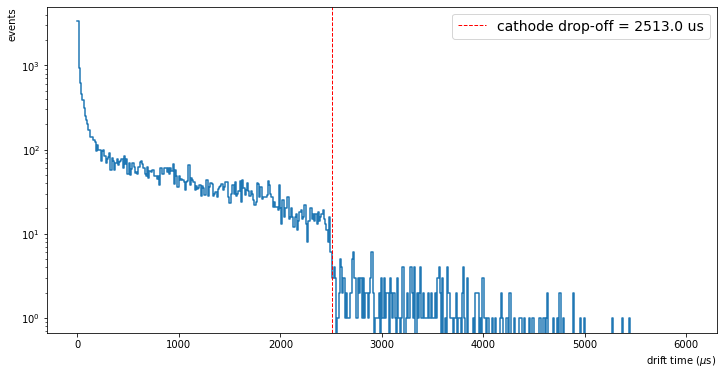

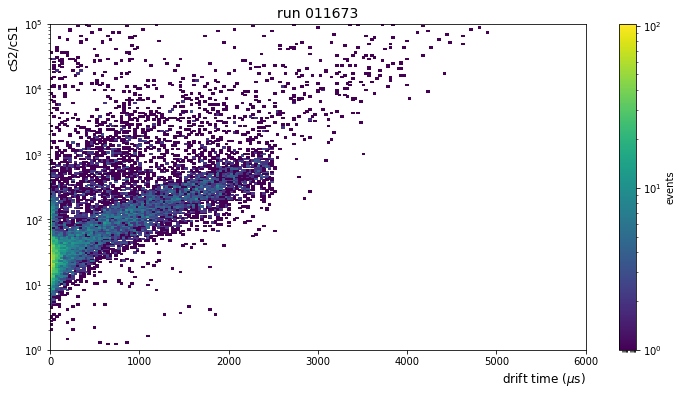

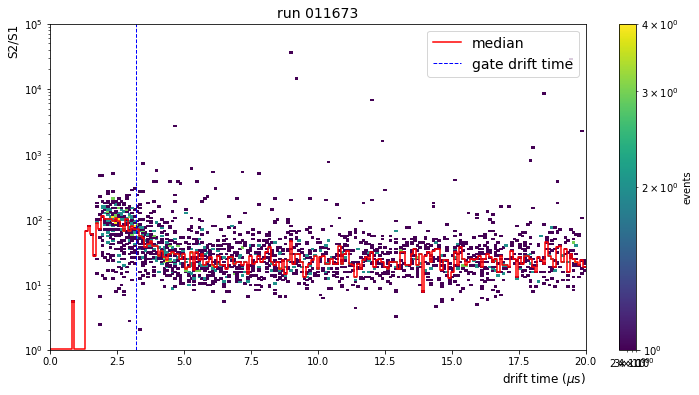

In [101]:
vd_kr = drift_velocity(run_kr,(1e4,1e7), (0,0.8), (1,1e7))

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

<ipython-input-100-4fd084f78b57>:22: RuntimeWarning: divide by zero encountered in true_divide
  area_ratio = np.divide(events['cs2'],events['cs1'])


Drift velocity = 730.96 m/s


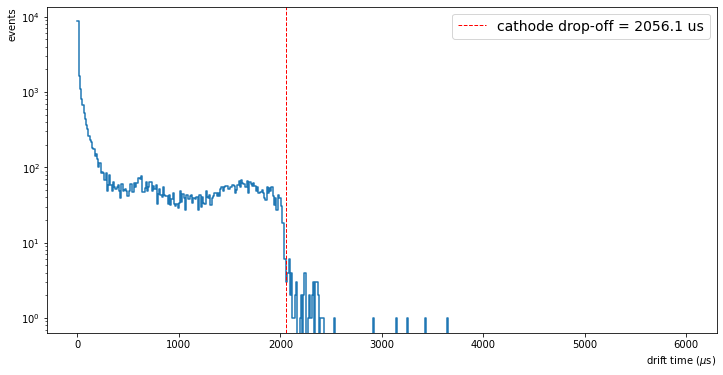

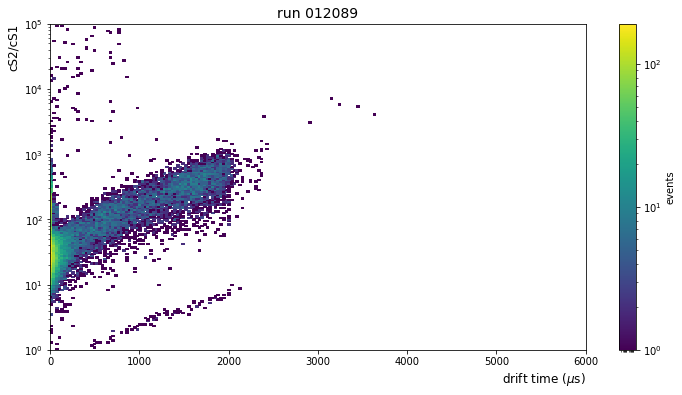

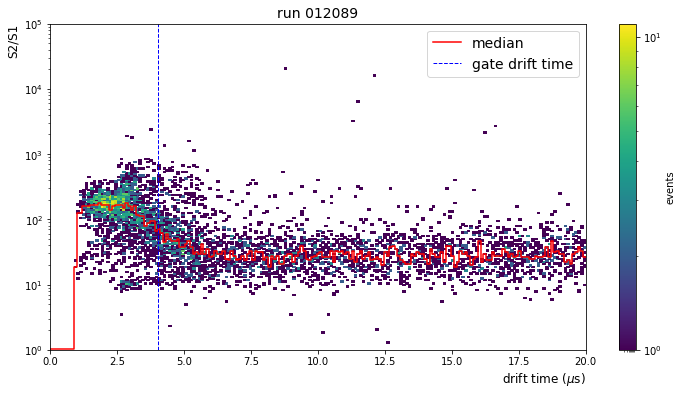

In [102]:
vd_bkg = drift_velocity(run_bkg,(1e4,1e7), (0,0.8), (1,1e7))

In [103]:
def diffusion_model(t, D, vd, w0):
    sigma_to_r50p = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)        
    return np.sqrt(2 * sigma_to_r50p**2 * D * t / vd**2 + w0**2)
def diffusion_constant(run_id, area_bounds, aft_bounds, width_bounds, fit_range, vd = 600):
    events = st.get_array(run_id,'event_info')

    data_cut = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2000, 200)
    ph = Histdd(data_cut['drift_time']/1e3, data_cut['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    
    #mean = np.array(ph.average(axis=1))
    #plt.plot(t[:len(mean)], mean, color='r',linestyle='-', label='mean per drift time slice')
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    plt.plot(t[:len(perc50)], perc50, color='b',linestyle='--', label='50% percentile')
    
    D_guess = 45e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    print(f'Drift velocity = {vd:.2f} m/s ')
    vd = vd * units.m / units.s
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = diffusion_model(t, *guess)
    #plt.plot(t, ys_m, c='yellow',linestyle='--',label='initial guess')
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: diffusion_model(x, D, vd, w0)
    #popt, pcov = curve_fit(diffusion, t[ll:hh], mean[ll:hh], p0=(D_guess, w0_guess))
    popt, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    ys_u = diffusion(t, *popt) + 1000
    ys_m = diffusion(t, *popt)
    ys_d = diffusion(t, *popt) - 1000

    plt.plot(t, ys_m, label=f'$D = {popt[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='r')
    plt.plot(t, ys_u,color='r')
    plt.plot(t, ys_d,color='r')
    plt.legend(fontsize=14)
    #print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} +/- {perr[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'w0 = {popt[1]/(units.ns):.2f} +/- {perr[1]/(units.ns):.2f} ns ')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 597.65 m/s 
Diffusion constant = 35.64 cm^2/s 
w0 = 0.03 +/- inf ns 


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


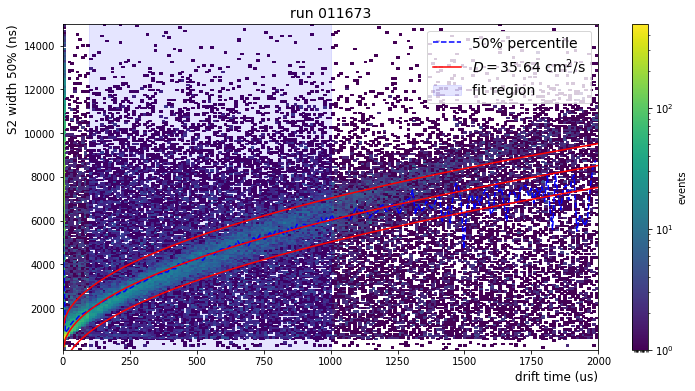

In [104]:
diffusion_constant(run_kr, (2e3,1e7), (0,0.8), (1,1e7),fit_range=(100,1000),vd = vd_kr)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 730.96 m/s 
Diffusion constant = 71.17 cm^2/s 
w0 = 1025.34 +/- 90.46 ns 


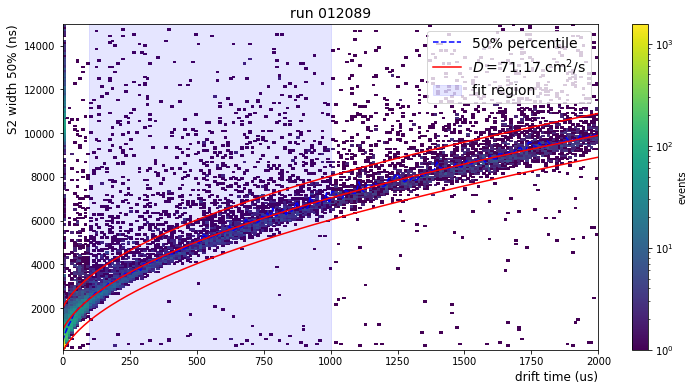

In [105]:
diffusion_constant(run_bkg, (2e3,1e7), (0,0.8), (1,1e7),fit_range=(100,1000),vd = vd_bkg)